In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import pickle
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
from plot_functions import *
import os

In [13]:
directory = os.path.expanduser('~/git/pred_graph/Austin_to_SanDiego/transfer')
if not os.path.exists(directory):
    print "not exist"

In [20]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        try:
            return pickle.load(f)
        except EOFError:
            return None

In [83]:
pred = load_obj('pred_graph/Austin_to_SanDiego/transfer/0-10.0')

In [84]:
gt_df = create_matrix_single_region('SanDiego', 2014)[0]
pred_copy = pred['Predictions'].copy()

In [111]:
from sklearn.metrics import mean_squared_error

def compute_rmse_fraction_overall(pred, region, year):
    count = 0
    pred_copy = pred.copy()
    for appliance in APPLIANCES_ORDER[1:]:
        start = 1
        stop = 13
        pred_appliance = pred_copy[appliance]
        pred_appliance.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
        df_app = pd.DataFrame(pred_appliance)
        if count == 0:
            pred_df = df_app
        else:
            pred_df = pd.concat([pred_df, df_app], axis=1)
        count += 1
    gt = gt_df[pred_df.columns].ix[pred_df.index]
    aggregate_df = gt_df.ix[pred_df.index][['aggregate_%d' % month for month in range(start, stop)]]
    
    rows, cols = np.where((aggregate_df < 100))
    for r, c in zip(rows, cols):
        r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
        aggregate_df.loc[r_i, c_i] = np.NaN
    gt_fraction = gt_df.copy()
    pred_fraction = pred_df.copy()
    for appliance in APPLIANCES_ORDER[1:]:
        columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
        aggregate_df.columns = columns
        gt_fraction.loc[:, appliance+"_1":appliance+"_12"] = gt_fraction.loc[:, appliance+"_1":appliance+"_12"].div(aggregate_df) * 100
        pred_fraction.loc[:, appliance+"_1":appliance+"_12"] = pred_fraction.loc[:, appliance+"_1":appliance+"_12"].div(aggregate_df) * 100
    pred_fraction[pred_fraction > 100] = 100.

    gt_fraction_dropna = gt_fraction.unstack().dropna()
    pred_fraction_dropna = pred_fraction.unstack().dropna()
    index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
    gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
    pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
    difference_error = (gt_fraction_dropna-pred_fraction_dropna).abs()

    rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
    return rms

In [112]:
pred = load_obj('pred_graph/Austin_to_SanDiego/transfer/0-10.0')

In [128]:
pred_normal = {}
for random_seed in range(5):
    pred_normal[random_seed] = {}
    for train_percentage in range(10, 110, 20):
        pred_normal[random_seed][train_percentage] = load_obj('pred_graph/Austin_to_SanDiego/normal/{}-{}'.format(random_seed, float(train_percentage)))['Predictions']

In [129]:
pred_transfer = {}
for random_seed in range(5):
    pred_transfer[random_seed] = {}
    for train_percentage in range(10, 110, 20):
        pred_transfer[random_seed][train_percentage] = load_obj('pred_graph/Austin_to_SanDiego/transfer/{}-{}'.format(random_seed, float(train_percentage)))['Predictions']

In [130]:
out_normal = {}
for random_seed in range(5):
    out_normal[random_seed] = {}
    for train_percentage in range(10, 110, 20):
        out_normal[random_seed][train_percentage] = compute_rmse_fraction_overall(pred_normal[random_seed][train_percentage], 'SanDiego', 2014)

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [131]:
out_transfer = {}
for random_seed in range(5):
    out_transfer[random_seed] = {}
    for train_percentage in range(10, 110, 20):
        out_transfer[random_seed][train_percentage] = compute_rmse_fraction_overall(pred_transfer[random_seed][train_percentage], 'SanDiego', 2014)

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [132]:
mean_normal = pd.DataFrame(out_normal).mean(axis=1)

In [133]:
mean_transfer = pd.DataFrame(out_transfer).mean(axis=1)

[[12.94382, 9.15144, 8.12822, 8.37829, 7.42771], [9.3466, 8.19155, 7.74555, 7.65324, 7.44007]]


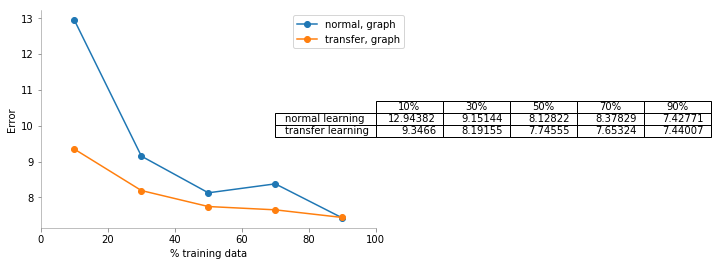

In [163]:
overall_res = {}
overall_res['normal, graph'] = mean_normal
overall_res['transfer, graph'] = mean_transfer

round_normal = [round(ele, 5) for ele in mean_normal.values.tolist()]
round_transfer = [round(ele, 5) for ele in mean_transfer.values.tolist()]

# myRoundedList = [ round(elem, 2) for elem in myList ]
# for name, df in d_res.iteritems():
#     overall_res[name] = (df*pd.Series(contri['SanDiego'])).sum(axis=1)

pd.DataFrame(overall_res).plot(marker='o')

col_labels=['10%','30%','50%', '70%', '90%']
row_labels=['normal learning','transfer learning']
table_vals=[round_normal, round_transfer]
print table_vals
# the rectangle is where I want to place the table

the_table = plt.table(cellText=table_vals,
                  colWidths = [0.2]*5,
                 
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='right')
plt.legend(loc ='best', bbox_to_anchor=(1.1, 1))
plt.ylabel("Error")
plt.xlim((0, 100))
plt.xlabel("% training data")
format_axes(plt.gca())



plt.savefig("./analysis/08/graph_laplacian_nested_cv_overall_rmse.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [150]:
col_labels=['10%','30%','50%', '70%', '90%']
row_labels=['normal learning','transfer learning']
table_vals=[mean_normal.values.tolist(), mean_transfer.values.tolist()]
print table_vals
# the rectangle is where I want to place the table
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*5,
                  rowLabels=row_labels,
                  colLabels=col_labels
                  )
plt.text(12,3.4,'Table Title',size=8)

plt.plot()
plt.show()

[[12.943816275901401, 9.151441135651805, 8.128222704083475, 8.378291986720189, 7.427705747376915], [9.346595399024011, 8.191549468833056, 7.7455463024995, 7.653244977678095, 7.440066358482037]]


In [85]:
count = 0

for appliance in APPLIANCES_ORDER[1:]:
    print appliance
    start = 1
    stop = 13
    pred_appliance = pred_copy[appliance]
    pred_appliance.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
    df_app = pd.DataFrame(pred_appliance)
    if count == 0:
        pred_df = df_app
    else:
        pred_df = pd.concat([pred_df, df_app], axis=1)
    count += 1
        


hvac
fridge
mw
dw
wm
oven


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [87]:
rows, cols = np.where((aggregate_df < 100))
for r, c in zip(rows, cols):
    r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
    aggregate_df.loc[r_i, c_i] = np.NaN

In [90]:
gt_fraction = gt_df.copy()
pred_fraction = pred_df.copy()
for appliance in APPLIANCES_ORDER[1:]:
    columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
    aggregate_df.columns = columns
    gt_fraction.loc[:, appliance+"_1":appliance+"_12"] = gt_fraction.loc[:, appliance+"_1":appliance+"_12"].div(aggregate_df) * 100
    pred_fraction.loc[:, appliance+"_1":appliance+"_12"] = pred_fraction.loc[:, appliance+"_1":appliance+"_12"].div(aggregate_df) * 100

In [93]:
pred_fraction[pred_fraction > 100] = 100.

In [95]:
from sklearn.metrics import mean_squared_error

gt_fraction_dropna = gt_fraction.unstack().dropna()
pred_fraction_dropna = pred_fraction.unstack().dropna()
index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
difference_error = (gt_fraction_dropna-pred_fraction_dropna).abs()

rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [96]:
rms

10.41629660549154

In [ ]:
def compute_rmse_fraction_overall(pred_df, region='Austin',year=2014):
    gt_df = create_matrix_single_region(region, 2014)[0]
    
    
    
    for appliance in APPLIANCES_ORDER[1:]:
    if appliance == "hvac":
        start, stop = 5, 11
    else:
        start, stop = 1, 13
    
    pred_df.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
    gt_df = appliance_df[pred_df.columns].ix[pred_df.index]

    aggregate_df = appliance_df.ix[pred_df.index][['aggregate_%d' % month for month in range(start, stop)]]

    aggregate_df.columns = gt_df.columns
    rows, cols = np.where((aggregate_df < 100))
    for r, c in zip(rows, cols):
        r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
        aggregate_df.loc[r_i, c_i] = np.NaN

    gt_fraction = gt_df.div(aggregate_df) * 100
    pred_fraction = pred_df.div(aggregate_df) * 100

    # Capping it to 100%
    pred_fraction[pred_fraction > 100] = 100.

    gt_fraction_dropna = gt_fraction.unstack().dropna()
    pred_fraction_dropna = pred_fraction.unstack().dropna()
    index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
    gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
    pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
    difference_error = (gt_fraction_dropna-pred_fraction_dropna).abs()

    rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
    return gt_fraction_dropna, pred_fraction_dropna, rms, difference_error
